In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf

from utils import (
    create_sine_wave,
    quantize_signal,
    simulate_network_latency,
    simulate_packet_loss,
    encode_signal,
    decode_signal,
    plot_signal_subplot,
)

In [2]:
# 1.a. Création d'un signal de référence
frequency = 2000  # 2kHz
duration = 3  # 3 seconds
sample_rate = frequency * 10  # 10 échantillons par période
t, signal = create_sine_wave(frequency, duration, sample_rate)

# Play the sine wave
sd.play(signal, sample_rate)
sd.wait()

In [3]:
# 1.b+c Quantifier ce signal en utilisant différentes résolutions
quantized_signal_8bit = np.round(signal * 127).astype(np.int8)
quantized_signal_6bit = quantize_signal(signal, 6)
quantized_signal_4bit = quantize_signal(signal, 4)
quantized_signal_3bit = quantize_signal(signal, 3)
quantized_signal_2bit = quantize_signal(signal, 2)
quantized_signal_1bit = quantize_signal(signal, 1)

1. d. Quand la résolution du quantificateur devient 1 bit/éch, le signal de sortie est une onde carrée. La fréquence de l'onde carrée est égale à la fréquence du signal d'entrée. La forme d'onde carrée est obtenue en comparant le signal d'entrée avec une onde sinusoïdale de fréquence égale à celle du signal d'entrée.

2. Le sens de l'ouïe humaine est effectivement sensible à la latence. Des retards de transmission peuvent provoquer des échos ou des interruptions perceptibles dans le son. Des latences supérieures à 20-30 mspeuvent être perceptibles et gênantes pour l'utilisateur. Un codeur ne devrait jamais depasser 100 ms de latence pour éviter des interruptions perceptibles.

3. La perte de paquets peut être simulée en omettant certains paquets de la transmission. Cela peut entraîner des interruptions dans le signal audio. Avec une probabilité de perte de paquet de ( p = 10^{-3} ), la perte sera rare, mais avec ( p = 10^{-2} ), la perte sera plus fréquente et plus perceptible. impact sur la qualité audio et la robustesse du système de codage face à la perte de paquets.


In [4]:
# 2. Simuler la latence d'un réseau fonctionnant en mode paquet
latencies = [0, 1, 2, 3, 4]  # Différentes latences pour chaque paquet
packet_size = 2  # 2 échantillons par paquet
delayed_signal = simulate_network_latency(quantized_signal_8bit, packet_size, latencies)

In [5]:
# 3. Simulation de la perte de paquets
loss_probability_1 = 10**-3
loss_probability_2 = 10**-2
lost_signal_1 = simulate_packet_loss(quantized_signal_8bit, packet_size, loss_probability_1)
lost_signal_2 = simulate_packet_loss(quantized_signal_8bit, packet_size, loss_probability_2)

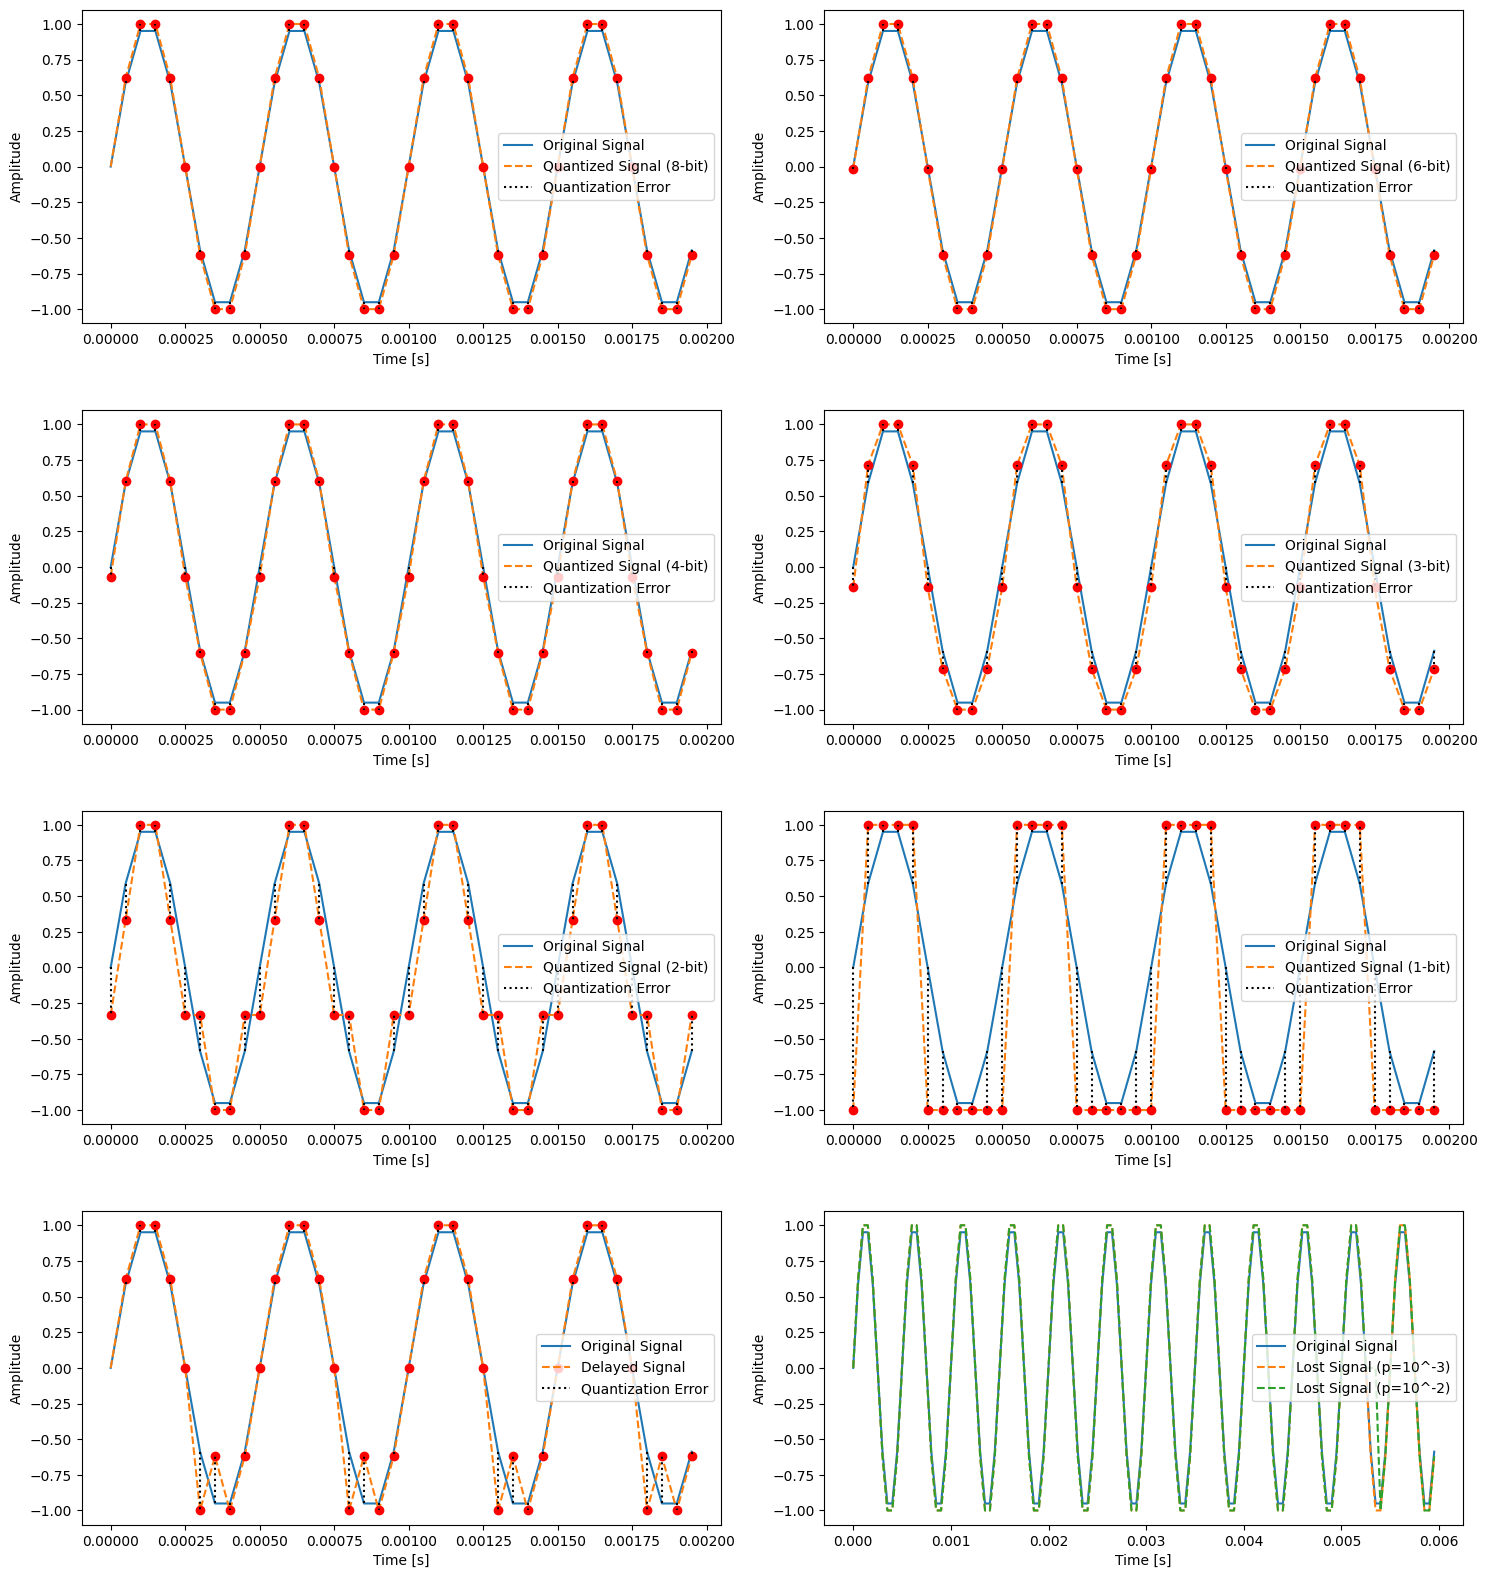

In [6]:

# Overlay Plots and Error Plots
slice_length = 40
t_slice = t[:slice_length]

plt.figure(figsize=(15, 18))

# Overlay plots
plot_signal_subplot(1, t_slice, signal[:slice_length], quantized_signal_8bit[:slice_length], 'Quantized Signal (8-bit)')
plot_signal_subplot(2, t_slice, signal[:slice_length], quantized_signal_6bit[:slice_length], 'Quantized Signal (6-bit)')
plot_signal_subplot(3, t_slice, signal[:slice_length], quantized_signal_4bit[:slice_length], 'Quantized Signal (4-bit)')
plot_signal_subplot(4, t_slice, signal[:slice_length], quantized_signal_3bit[:slice_length], 'Quantized Signal (3-bit)')
plot_signal_subplot(5, t_slice, signal[:slice_length], quantized_signal_2bit[:slice_length], 'Quantized Signal (2-bit)')
plot_signal_subplot(6, t_slice, signal[:slice_length], quantized_signal_1bit[:slice_length], 'Quantized Signal (1-bit)')

# Delayed signal
plot_signal_subplot(7, t_slice, signal[:slice_length], delayed_signal[:slice_length], 'Delayed Signal')

# Lost signal
slice_length = 3*slice_length
t_slice = t[:slice_length]
plt.subplot(4, 2, 8)
plt.plot(t_slice, signal[:slice_length], label='Original Signal')
plt.plot(t_slice, lost_signal_1[:slice_length]/np.max(lost_signal_1), label='Lost Signal (p=10^-3)', linestyle='--')
plt.plot(t_slice, lost_signal_2[:slice_length]/np.max(lost_signal_2), label='Lost Signal (p=10^-2)', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout(h_pad=4)
plt.subplots_adjust(bottom=0.15)
plt.show()

#### Partie 2: Simuler la latence d'un réseau fonctionnant en mode paquet

1. Les retards de transmission peuvent entraîner des interruptions perceptibles dans le signal audio. Des latences variables peuvent provoquer des distorsions et des échos, affectant ainsi la qualité de l'expérience auditive.

<Figure size 1500x1800 with 0 Axes>

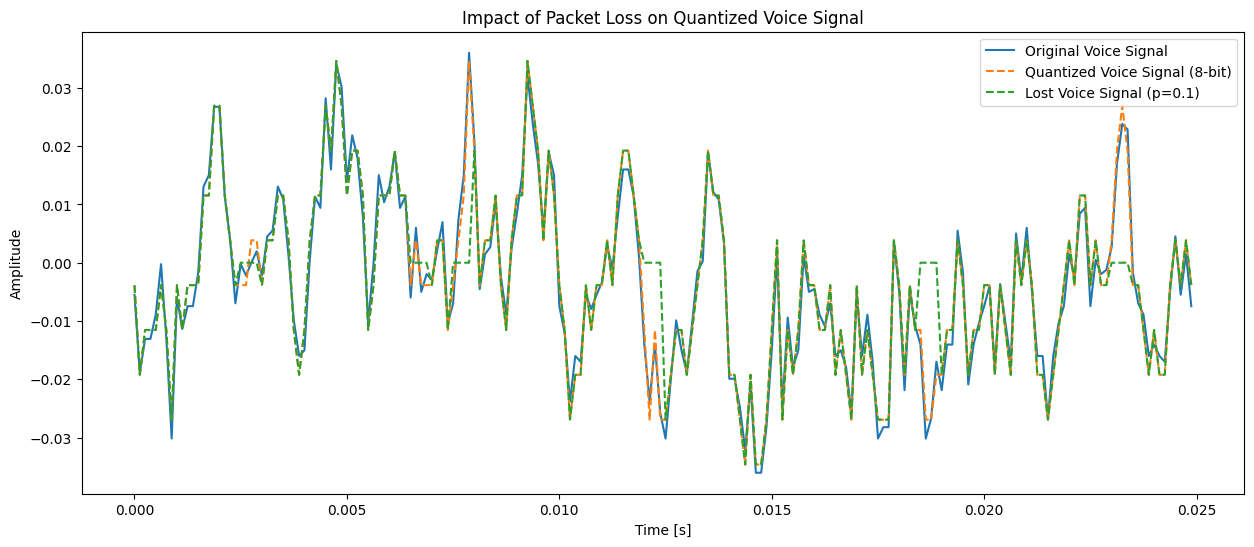

Taux de pertes de blocs de 4 octets: 10.0%


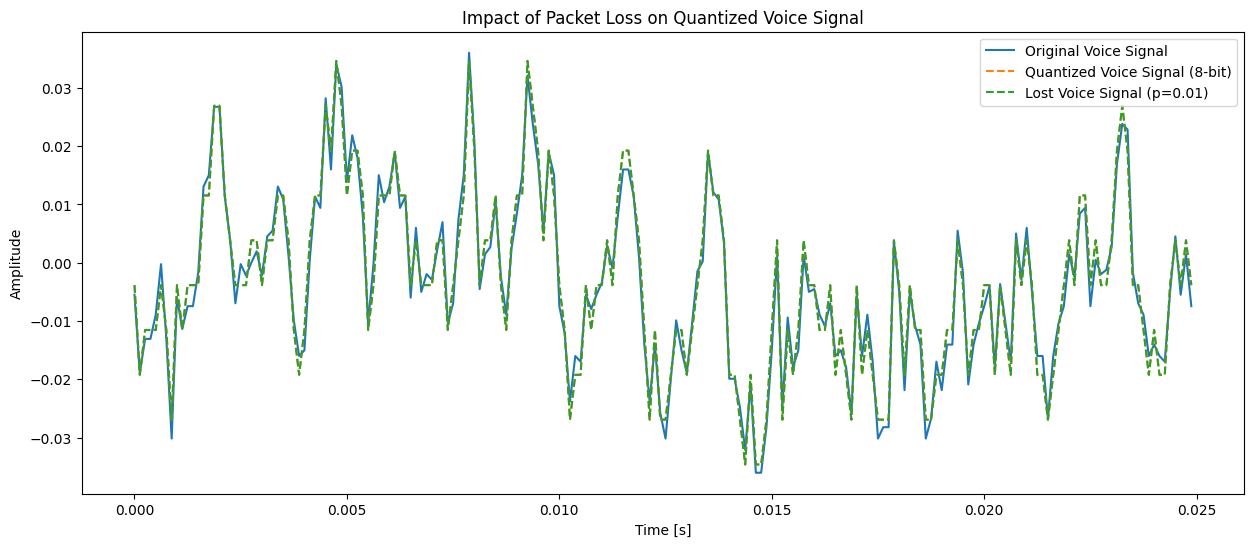

Taux de pertes de blocs de 4 octets: 1.0%


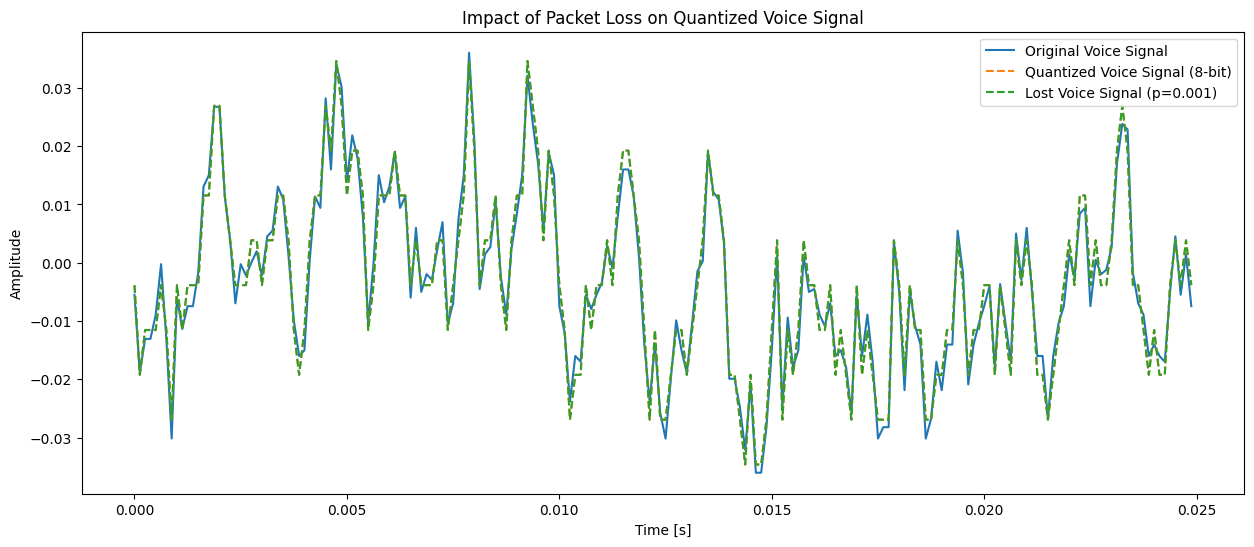

Taux de pertes de blocs de 4 octets: 0.1%


In [7]:
file_path = './xtineFs.wav'
voice_signal, voice_sample_rate = sf.read(file_path)

# Quantize the signal to 8 bits
quantized_voice_signal = quantize_signal(voice_signal, 8)

# Encode DPCM
encoded_voice_signal = encode_signal(quantized_voice_signal, encoding_type='DPCM')

# Create packets of 4 bytes (32 bits)
packet_size_bytes = 4
packet_size_samples = packet_size_bytes * 8 // 8  # 4 bytes = 4 samples of 8 bits

# List of loss probabilities to test
loss_probabilities = [0.1, 0.01, 0.001]

# Simulate packet loss and decode the lost signals
lost_voice_signals = []
decoded_lost_voice_signals = []

for loss_probability in loss_probabilities:
    lost_voice_signal = simulate_packet_loss(encoded_voice_signal, packet_size_samples, loss_probability)
    decoded_lost_voice_signal = decode_signal(lost_voice_signal, encoding_type='DPCM')
    lost_voice_signals.append(lost_voice_signal)
    decoded_lost_voice_signals.append(decoded_lost_voice_signal)

# Decode the original encoded signal
decoded_voice_signal = decode_signal(encoded_voice_signal, encoding_type='DPCM')

# Overlay Plots and Error Plots
slice_length = 200
t_voice = np.linspace(0, len(voice_signal) / voice_sample_rate, len(voice_signal))
t_voice_slice = t_voice[:slice_length]

plt.figure(figsize=(15, 18))

for i, loss_probability in enumerate(loss_probabilities):
    plt.figure(figsize=(15, 6))
    plt.plot(t_voice_slice, voice_signal[:slice_length], label='Original Voice Signal')
    plt.plot(t_voice_slice, quantized_voice_signal[:slice_length], label='Quantized Voice Signal (8-bit)', linestyle='--')
    plt.plot(t_voice_slice, decoded_lost_voice_signals[i][:slice_length], label=f'Lost Voice Signal (p={loss_probability})', linestyle='--')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.title('Impact of Packet Loss on Quantized Voice Signal')
    plt.show()

    print(f'Taux de pertes de blocs de 4 octets: {loss_probability * 100}%')